In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [5]:
np.set_printoptions(threshold=sys.maxsize)


# Load data: Merge & Concatenation

In [6]:
movie_metadata=pd.read_csv('./movie_metadata.csv')
movie_metadata
df = movie_metadata

FileNotFoundError: [Errno 2] No such file or directory: './movie_metadata.csv'

In [ ]:
df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,Eric Mabius,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,Natalie Zea,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,Alan Ruck,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660


# Explore data:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              4939 non-null   object 
 1   num_critic_for_reviews     4993 non-null   float64
 2   duration                   5028 non-null   float64
 3   director_facebook_likes    4939 non-null   float64
 4   actor_3_facebook_likes     5020 non-null   float64
 5   actor_2_name               5030 non-null   object 
 6   actor_1_facebook_likes     5036 non-null   float64
 7   gross                      4159 non-null   float64
 8   genres                     5043 non-null   object 
 9   actor_1_name               5036 non-null   object 
 10  movie_title                5043 non-null   object 
 11  num_voted_users            5043 non-null   int64  
 12  cast_total_facebook_likes  5043 non-null   int64  
 13  actor_3_name               5020 non-null   objec

### Fix in missing value in train dataset

Number of missing values

In [ ]:
df.isna().sum()

director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [ ]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [ ]:
df.value_counts()

director_name     num_critic_for_reviews  duration  director_facebook_likes  actor_3_facebook_likes  actor_2_name         actor_1_facebook_likes  gross       genres                                actor_1_name         movie_title          num_voted_users  cast_total_facebook_likes  actor_3_name     facenumber_in_poster  plot_keywords                                                      movie_imdb_link                                       num_user_for_reviews  language  country      content_rating  budget      title_year  actor_2_facebook_likes  imdb_score  aspect_ratio  movie_facebook_likes
Frank Oz          168.0                   87.0      0.0                      548.0                   Ewen Bremner         22000.0                 8579684.0   Comedy                                Peter Dinklage       Death at a Funeral   89547            24324                      Kris Marshall    0.0                   end credits roll call|four word title|funeral|secret|uncle         http://www.imd

<AxesSubplot:xlabel='imdb_score', ylabel='Count'>

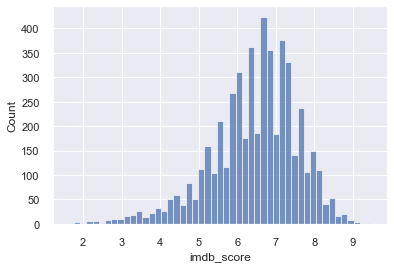

In [ ]:
sns.histplot(df['imdb_score'])

### Data cleaning

Label the high and low IMDB scores. The data in the middle 10 percentile, form 45-percentile to 55-percentile are removed.

The top section of the data are labeled as "high_imdb_score = 1" and the remaining are "high_imdb_score = 0"

6.4 6.7


<AxesSubplot:xlabel='imdb_score', ylabel='Count'>

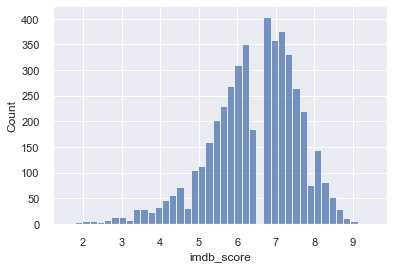

In [ ]:
percentile45 = df['imdb_score'].quantile(0.45)
percentile55 = df['imdb_score'].quantile(0.55)
print(percentile45, percentile55)
df = df.drop(df[(df['imdb_score'] > percentile45) & (df['imdb_score'] < percentile55)].index)
df
sns.histplot(df['imdb_score'])

In [ ]:
df['high_imdb_score'] = np.where(df['imdb_score'] >= percentile55 , 1, 0)
df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,high_imdb_score
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,1
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,1
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,1
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,1
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,Kerry Bishé,...,English,USA,Not Rated,9000.0,2011.0,205.0,6.4,NaN,413,0
5038,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,Eric Mabius,...,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84,1
5039,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,Natalie Zea,...,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000,1
5040,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,...,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16,0


In [ ]:
df = df.dropna(how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3441 entries, 0 to 5035
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              3441 non-null   object 
 1   num_critic_for_reviews     3441 non-null   float64
 2   duration                   3441 non-null   float64
 3   director_facebook_likes    3441 non-null   float64
 4   actor_3_facebook_likes     3441 non-null   float64
 5   actor_2_name               3441 non-null   object 
 6   actor_1_facebook_likes     3441 non-null   float64
 7   gross                      3441 non-null   float64
 8   genres                     3441 non-null   object 
 9   actor_1_name               3441 non-null   object 
 10  movie_title                3441 non-null   object 
 11  num_voted_users            3441 non-null   int64  
 12  cast_total_facebook_likes  3441 non-null   int64  
 13  actor_3_name               3441 non-null   objec

In [ ]:
original_rows = df.shape[0]
dropped_rows = original_rows - df.shape[0]
percent_dropped = 100 * dropped_rows / original_rows
print("Percentage of rows dropped: {:.2f}%".format(percent_dropped))

Percentage of rows dropped: 0.00%


In [ ]:
df.describe().round(0)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,high_imdb_score
count,3441.0,3441.0,3441.0,3441.0,3441.0,3441.0,3441.0,3441.0,3441.0,3441.0,3.441000e+03,3441.0,3441.0,3441.0,3441.0,3441.0,3441.0
mean,168.0,110.0,818.0,773.0,7678.0,52825981.0,108432.0,11447.0,1.0,343.0,4.669174e+07,2003.0,2014.0,6.0,2.0,9638.0,1.0
std,125.0,23.0,3091.0,1911.0,15879.0,70975873.0,156842.0,19431.0,2.0,416.0,2.356551e+08,10.0,4564.0,1.0,0.0,22047.0,1.0
min,2.0,37.0,0.0,0.0,0.0,162.0,91.0,0.0,0.0,4.0,2.180000e+02,1927.0,0.0,2.0,1.0,0.0,0.0
25%,77.0,96.0,11.0,194.0,744.0,8406264.0,19671.0,1920.0,0.0,111.0,1.000000e+07,1999.0,387.0,6.0,2.0,0.0,0.0
50%,139.0,106.0,64.0,435.0,1000.0,30012990.0,53341.0,3962.0,1.0,211.0,2.500000e+07,2004.0,683.0,7.0,2.0,251.0,1.0
75%,224.0,120.0,243.0,687.0,12000.0,66862068.0,132423.0,16196.0,2.0,409.0,5.000000e+07,2010.0,973.0,7.0,2.0,11000.0,1.0
max,813.0,330.0,22000.0,23000.0,640000.0,760505847.0,1689764.0,656730.0,43.0,5060.0,1.221550e+10,2016.0,137000.0,9.0,16.0,349000.0,1.0


# Preprocess data

### Onehot encode

In [ ]:
df['director_name'].value_counts()

Steven Spielberg    23
Woody Allen         18
Martin Scorsese     16
Clint Eastwood      16
Ridley Scott        15
                    ..
John Fortenberry     1
Daniel Barnz         1
Jason Moore          1
Trent Cooper         1
Shane Carruth        1
Name: director_name, Length: 1581, dtype: int64

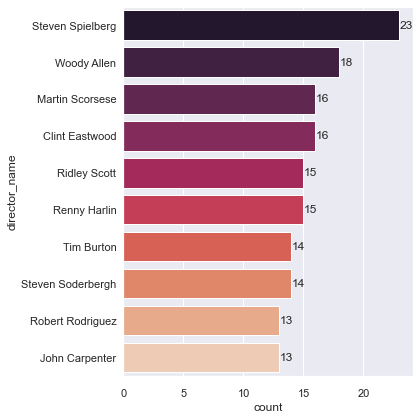

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['director_name'], order=df['director_name'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [ ]:
df['actor_1_name'].value_counts()

Robert De Niro       41
Johnny Depp          35
J.K. Simmons         28
Nicolas Cage         27
Denzel Washington    25
                     ..
Marisa Saks           1
Peter Firth           1
Isaiah Washington     1
Johnny Lewis          1
Carlos Gallardo       1
Name: actor_1_name, Length: 1356, dtype: int64

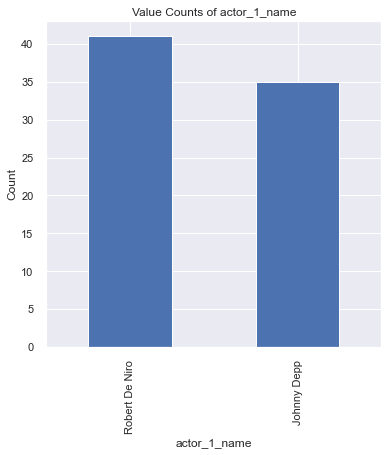

In [ ]:
value_counts = df['actor_1_name'].value_counts()
value_counts = value_counts[value_counts>=30]
value_counts.plot(kind='bar')
plt.xlabel('actor_1_name')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('actor_1_name'))
plt.show()

In [ ]:
df['actor_2_name'].value_counts()

Morgan Freeman     17
Charlize Theron    14
Brad Pitt          14
James Franco       10
Will Ferrell        9
                   ..
Deborah Twiss       1
Lily Rabe           1
Omri Katz           1
Noah Lomax          1
Peter Marquardt     1
Name: actor_2_name, Length: 2077, dtype: int64

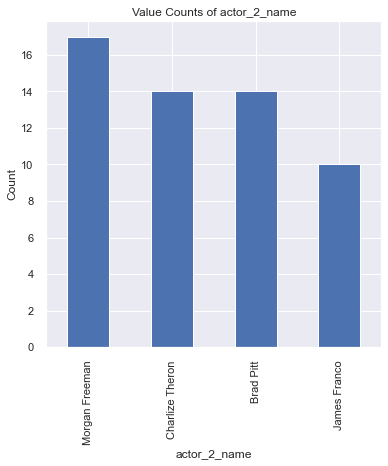

In [ ]:
value_counts = df['actor_2_name'].value_counts()
value_counts = value_counts[value_counts>=10]
value_counts.plot(kind='bar')
plt.xlabel('actor_2_name')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('actor_2_name'))
plt.show()

In [ ]:
df['actor_3_name'].value_counts()

Steve Coogan           8
Kirsten Dunst          7
Clifton Collins Jr.    6
Ben Mendelsohn         6
Craig T. Nelson        6
                      ..
Peter Sallis           1
Tanya Roberts          1
Priscilla Presley      1
Anne Meara             1
Consuelo Gómez         1
Name: actor_3_name, Length: 2418, dtype: int64

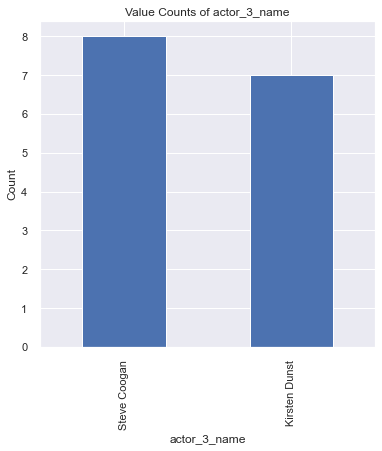

In [ ]:
value_counts = df['actor_3_name'].value_counts()
value_counts = value_counts[value_counts>=7]
value_counts.plot(kind='bar')
plt.xlabel('actor_3_name')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('actor_3_name'))
plt.show()

In [ ]:
df['genres'].value_counts()

Drama                                          130
Comedy|Drama|Romance                           129
Comedy                                         128
Comedy|Drama                                   125
Comedy|Romance                                 118
                                              ... 
Action|Adventure|Drama|Thriller|Western          1
Animation|Comedy|Family|Horror|Sci-Fi            1
Action|Drama|Sci-Fi|Sport                        1
Adventure|Comedy|Drama|Romance|Thriller|War      1
Comedy|Crime|Horror                              1
Name: genres, Length: 719, dtype: int64

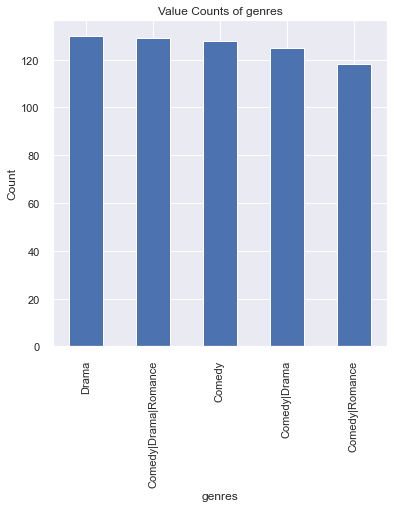

In [ ]:
value_counts = df['genres'].value_counts()
value_counts = value_counts[value_counts>=110]
value_counts.plot(kind='bar')
plt.xlabel('genres')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('genres'))
plt.show()

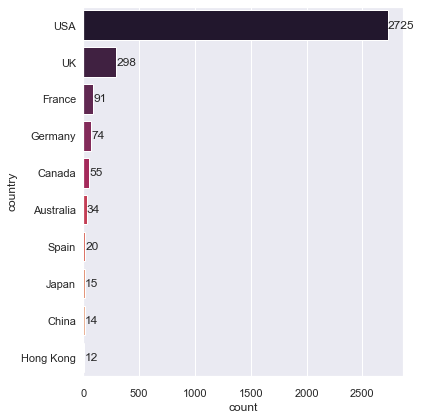

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['country'], order=df['country'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

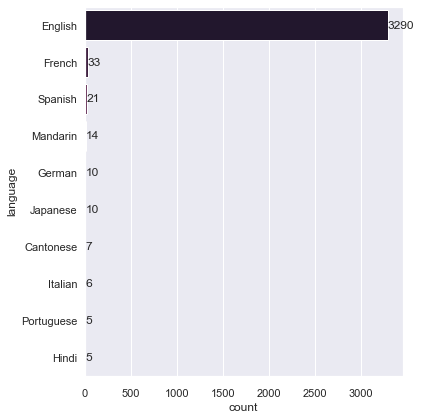

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['language'], order=df['language'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [ ]:
df['content_rating'].value_counts()

R            1535
PG-13        1213
PG            521
G              80
Not Rated      34
Unrated        20
Approved       17
X               9
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

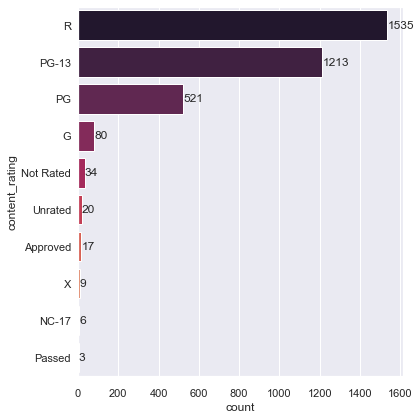

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(y=df['content_rating'], order=df['content_rating'].value_counts().iloc[:10].index, palette='rocket')
ax.tick_params(axis='y', length=0)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [ ]:
df['language'].value_counts()

English       3290
French          33
Spanish         21
Mandarin        14
German          10
Japanese        10
Cantonese        7
Italian          6
Portuguese       5
Hindi            5
Korean           5
Norwegian        4
Danish           3
Persian          3
Dutch            3
Dari             2
Indonesian       2
Aboriginal       2
Thai             2
Aramaic          1
Hungarian        1
Kazakh           1
Maya             1
Filipino         1
Mongolian        1
Czech            1
None             1
Zulu             1
Hebrew           1
Arabic           1
Vietnamese       1
Bosnian          1
Romanian         1
Name: language, dtype: int64

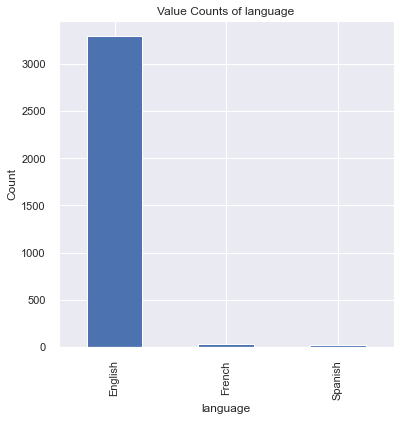

In [ ]:
value_counts = df['language'].value_counts()
value_counts = value_counts[value_counts>=20]
value_counts.plot(kind='bar')
plt.xlabel('language')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('language'))
plt.show()

In [ ]:
df['country'].value_counts()

USA               2725
UK                 298
France              91
Germany             74
Canada              55
Australia           34
Spain               20
Japan               15
China               14
Hong Kong           12
New Zealand         11
Italy                9
South Korea          8
Denmark              8
Ireland              7
Mexico               5
Brazil               5
India                5
Norway               4
Iran                 3
Argentina            3
Thailand             3
Netherlands          3
Czech Republic       3
Hungary              2
Taiwan               2
Romania              2
South Africa         2
Russia               2
Peru                 1
New Line             1
Indonesia            1
Israel               1
Poland               1
Colombia             1
Iceland              1
Finland              1
Aruba                1
Georgia              1
West Germany         1
Chile                1
Official site        1
Greece               1
Belgium    

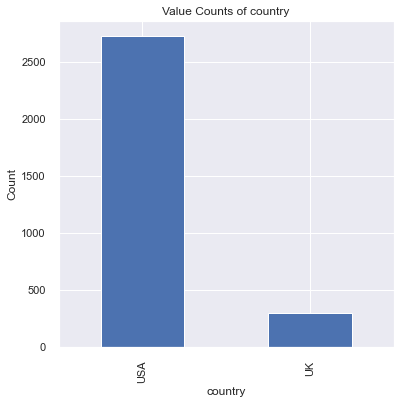

In [ ]:
value_counts = df['country'].value_counts()
value_counts = value_counts[value_counts>=100]
value_counts.plot(kind='bar')
plt.xlabel('country')
plt.ylabel('Count')
plt.title('Value Counts of {}'.format('country'))
plt.show()

In [ ]:
df_dropped = df.drop(columns=['movie_title','actor_3_name','plot_keywords','movie_imdb_link', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes'])
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3441 entries, 0 to 5035
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              3441 non-null   object 
 1   num_critic_for_reviews     3441 non-null   float64
 2   duration                   3441 non-null   float64
 3   director_facebook_likes    3441 non-null   float64
 4   actor_2_name               3441 non-null   object 
 5   gross                      3441 non-null   float64
 6   genres                     3441 non-null   object 
 7   actor_1_name               3441 non-null   object 
 8   num_voted_users            3441 non-null   int64  
 9   cast_total_facebook_likes  3441 non-null   int64  
 10  facenumber_in_poster       3441 non-null   float64
 11  num_user_for_reviews       3441 non-null   float64
 12  language                   3441 non-null   object 
 13  country                    3441 non-null   objec

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = ""

def onehot_encode_top_n(df, column, n):
    values_count = df[column].value_counts()
    frequent_values = values_count[values_count >= n].index
    df[column] = df[column].where(df[column].isin(frequent_values), 'others')

    onehot = OneHotEncoder()
    onehot_array = onehot.fit_transform(df[[column]]).toarray()
    onehot_labels = [f"{column}:{val}" for val in onehot.categories_[0]]
    onehot_df = pd.DataFrame(onehot_array, columns=onehot_labels)
    df = pd.concat([df.reset_index(drop = True), onehot_df.reset_index(drop=True)], axis=1)

    return df

custom_df_dropped = onehot_encode_top_n(df_dropped, "director_name", 19)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "country", 2900)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "language", 3500)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "content_rating", 500)
custom_df_dropped = onehot_encode_top_n(custom_df_dropped, "genres", 125)
custom_df_dropped

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_2_name,gross,genres,actor_1_name,num_voted_users,cast_total_facebook_likes,...,language:others,content_rating:PG,content_rating:PG-13,content_rating:R,content_rating:others,genres:Comedy,genres:Comedy|Drama,genres:Comedy|Drama|Romance,genres:Drama,genres:others
0,others,723.0,178.0,0.0,Joel David Moore,760505847.0,others,CCH Pounder,886204,4834,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,others,302.0,169.0,563.0,Orlando Bloom,309404152.0,others,Johnny Depp,471220,48350,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,others,602.0,148.0,0.0,Rory Kinnear,200074175.0,others,Christoph Waltz,275868,11700,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,others,813.0,164.0,22000.0,Christian Bale,448130642.0,others,Tom Hardy,1144337,106759,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,others,392.0,156.0,0.0,James Franco,336530303.0,others,J.K. Simmons,383056,46055,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,others,73.0,108.0,0.0,Mink Stole,180483.0,others,Divine,16792,760,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3437,others,81.0,110.0,107.0,Béatrice Dalle,136007.0,others,Maggie Cheung,3924,776,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3438,others,64.0,90.0,397.0,Nargess Mamizadeh,673780.0,Drama,Fereshteh Sadre Orafaiy,4555,5,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3439,others,143.0,77.0,291.0,David Sullivan,424760.0,others,Shane Carruth,72639,368,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_dropped = custom_df_dropped.copy()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441 entries, 0 to 3440
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   director_name                   3441 non-null   object 
 1   num_critic_for_reviews          3441 non-null   float64
 2   duration                        3441 non-null   float64
 3   director_facebook_likes         3441 non-null   float64
 4   actor_2_name                    3441 non-null   object 
 5   gross                           3441 non-null   float64
 6   genres                          3441 non-null   object 
 7   actor_1_name                    3441 non-null   object 
 8   num_voted_users                 3441 non-null   int64  
 9   cast_total_facebook_likes       3441 non-null   int64  
 10  facenumber_in_poster            3441 non-null   float64
 11  num_user_for_reviews            3441 non-null   float64
 12  language                        34

array([[<AxesSubplot:title={'center':'num_critic_for_reviews'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'director_facebook_likes'}>,
        <AxesSubplot:title={'center':'gross'}>,
        <AxesSubplot:title={'center':'num_voted_users'}>],
       [<AxesSubplot:title={'center':'cast_total_facebook_likes'}>,
        <AxesSubplot:title={'center':'facenumber_in_poster'}>,
        <AxesSubplot:title={'center':'num_user_for_reviews'}>,
        <AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'title_year'}>],
       [<AxesSubplot:title={'center':'imdb_score'}>,
        <AxesSubplot:title={'center':'aspect_ratio'}>,
        <AxesSubplot:title={'center':'movie_facebook_likes'}>,
        <AxesSubplot:title={'center':'high_imdb_score'}>,
        <AxesSubplot:title={'center':'director_name:Steven Spielberg'}>],
       [<AxesSubplot:title={'center':'director_name:others'}>,
        <AxesSubplot:title={'center':'country:ot

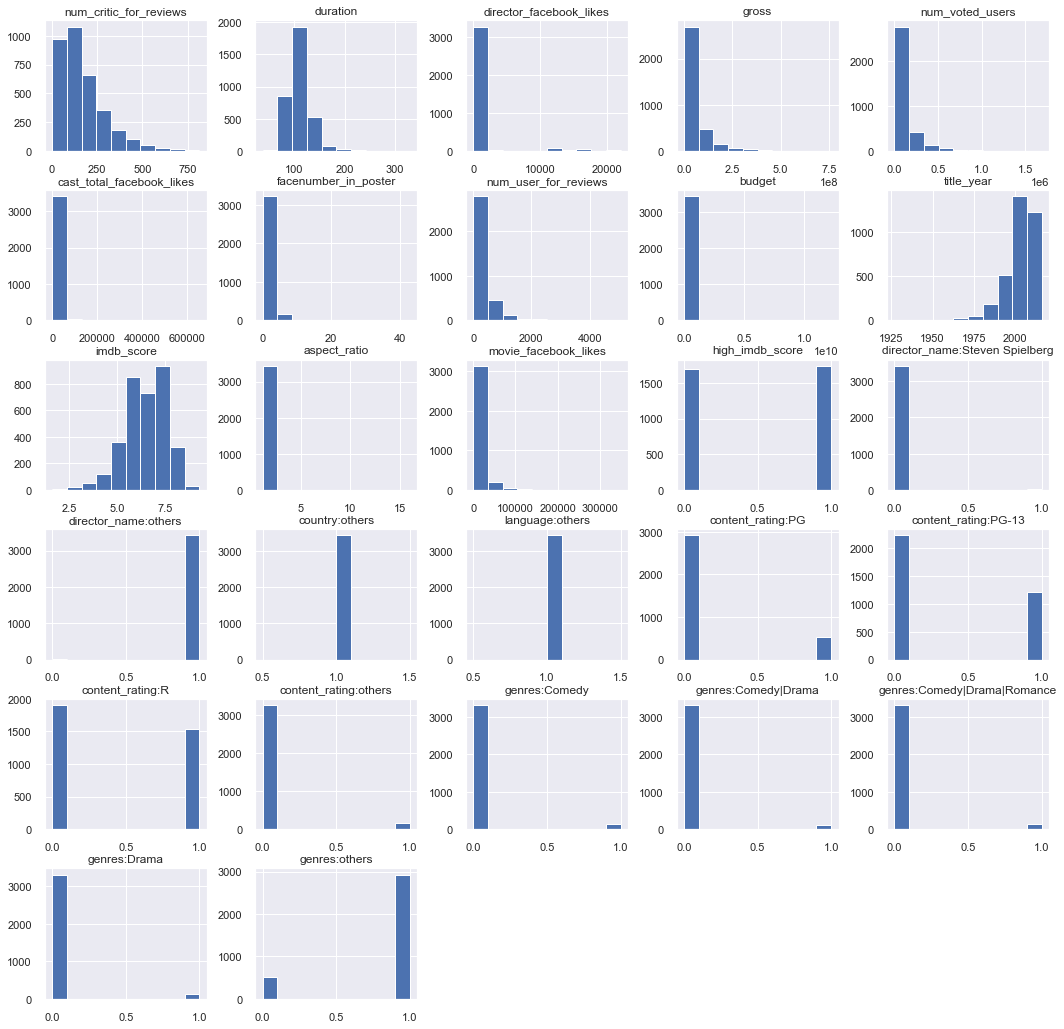

In [ ]:
sns.set(rc={'figure.figsize':(18,18)})
df_dropped.hist()

In [ ]:
numerical_cols = df_dropped._get_numeric_data().columns.tolist()
numerical_features=list(set(numerical_cols)-set(['imdb_score', 'high_imdb_score']))

df_dropped = df_dropped[numerical_cols]

In [ ]:
target_names=['high_imdb_score', 'low_imdb_score']

movie_score_target = pd.DataFrame(df_dropped['high_imdb_score'])
movie_score_target


,high_imdb_score
0,1
1,1
2,1
3,1
4,0
...,...
3436,0
3437,1
3438,1
3439,1


In [ ]:
movie_score_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441 entries, 0 to 3440
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   high_imdb_score  3441 non-null   int64
dtypes: int64(1)
memory usage: 27.0 KB


In [ ]:
movie_score_target.value_counts()

high_imdb_score
1                  1740
0                  1701
dtype: int64

### Split train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped, movie_score_target, test_size=0.2,shuffle=True,stratify=movie_score_target,random_state=30)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train value counts: {y_train.value_counts()}")
print(f"y_test value counts: {y_test.value_counts()}")

X_train shape: (2752, 27)
X_test shape: (689, 27)
y_train value counts: high_imdb_score
1                  1392
0                  1360
dtype: int64
y_test value counts: high_imdb_score
1                  348
0                  341
dtype: int64


In [ ]:
y_test.sort_index().head()

,high_imdb_score
0,1
3,1
9,0
13,1
17,1


In [ ]:
X_train = X_train.drop(['imdb_score', 'high_imdb_score'], axis = 1)
X_test = X_test.drop(['imdb_score', 'high_imdb_score'], axis = 1)
X_train

,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,...,language:others,content_rating:PG,content_rating:PG-13,content_rating:R,content_rating:others,genres:Comedy,genres:Comedy|Drama,genres:Comedy|Drama|Romance,genres:Drama,genres:others
700,181.0,107.0,192.0,7605668.0,47320,42683,2.0,188.0,60000000.0,2015.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2261,150.0,111.0,122.0,2203641.0,42792,1252,0.0,162.0,15000000.0,2008.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1015,362.0,129.0,456.0,166147885.0,220020,4585,0.0,1360.0,40000000.0,2015.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2543,242.0,97.0,482.0,52200504.0,54190,2426,0.0,183.0,10000000.0,2015.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1335,93.0,107.0,26.0,10956379.0,21506,3274,0.0,364.0,35000000.0,2007.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,11.0,89.0,15.0,4692814.0,2870,3291,2.0,34.0,8000000.0,1999.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2083,113.0,129.0,51.0,44469602.0,23480,952,0.0,83.0,17000000.0,2015.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
342,66.0,111.0,79.0,42877165.0,45602,26088,0.0,114.0,86000000.0,1997.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3384,40.0,90.0,44.0,4000000.0,6046,872,0.0,46.0,350000.0,1987.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Model

### Debug the Decision Tree model to make the model work for train dataset

examine the max_depth and min_salples_split values that are suitable for the train dataset 

In [ ]:
#Create DT Classifier
DT2=DecisionTreeClassifier(criterion='entropy', splitter='best',max_depth=5, min_samples_split=200)

#Train the model using the training sets
DT2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred =DT2.predict(X_test)

In [ ]:
DT2.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 200,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Classification Report: 
                  precision    recall  f1-score   support

high_imdb_score       0.73      0.85      0.79       341
 low_imdb_score       0.83      0.69      0.75       348

       accuracy                           0.77       689
      macro avg       0.78      0.77      0.77       689
   weighted avg       0.78      0.77      0.77       689
 

Accuracy on train:   0.778 

Accuracy on test:  0.771 



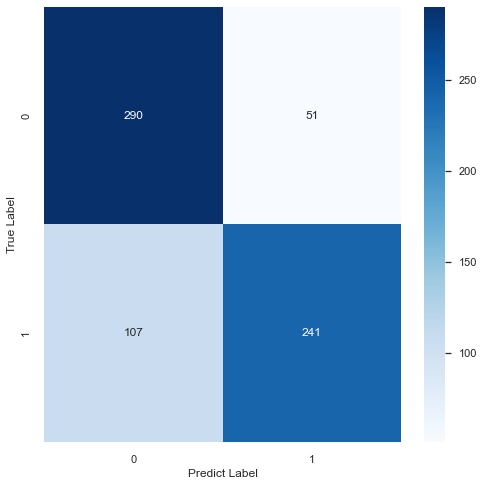

In [ ]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred,target_names=target_names),'\n')
print("Accuracy on train:  ",DT2.score(X_train,y_train).round(3),'\n')
print("Accuracy on test: ",DT2.score(X_test,y_test).round(3),'\n')
cf=metrics.confusion_matrix(y_test,y_pred).round(3)

sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(cf,annot=True,cmap='Blues', fmt="g")
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

### Evaluate classification result of test dataset

In [ ]:
print(export_text(DT2,feature_names=X_test.columns.tolist()))

|--- num_voted_users <= 177778.50
|   |--- duration <= 110.50
|   |   |--- budget <= 12550000.00
|   |   |   |--- num_voted_users <= 44949.00
|   |   |   |   |--- cast_total_facebook_likes <= 474.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cast_total_facebook_likes >  474.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- num_voted_users >  44949.00
|   |   |   |   |--- class: 1
|   |   |--- budget >  12550000.00
|   |   |   |--- num_voted_users <= 82555.50
|   |   |   |   |--- movie_facebook_likes <= 2500.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- movie_facebook_likes >  2500.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- num_voted_users >  82555.50
|   |   |   |   |--- class: 0
|   |--- duration >  110.50
|   |   |--- budget <= 31250000.00
|   |   |   |--- num_voted_users <= 8357.50
|   |   |   |   |--- class: 0
|   |   |   |--- num_voted_users >  8357.50
|   |   |   |   |--- budget <= 11500000.00
|   |   |   |   |   |--- class: 1
|   |   |   | 

In [ ]:
DT2.classes_

array([0, 1])

[Text(0.65, 0.9166666666666666, 'num_voted_users <= 177778.5\nentropy = 1.0\nsamples = 2752\nvalue = [1360, 1392]\nclass = low_imdb_score'),
 Text(0.38, 0.75, 'duration <= 110.5\nentropy = 0.98\nsamples = 2257\nvalue = [1314, 943]\nclass = high_imdb_score'),
 Text(0.2, 0.5833333333333334, 'budget <= 12550000.0\nentropy = 0.901\nsamples = 1494\nvalue = [1020, 474]\nclass = high_imdb_score'),
 Text(0.12, 0.4166666666666667, 'num_voted_users <= 44949.0\nentropy = 1.0\nsamples = 588\nvalue = [292, 296]\nclass = low_imdb_score'),
 Text(0.08, 0.25, 'cast_total_facebook_likes <= 474.5\nentropy = 0.971\nsamples = 437\nvalue = [262, 175]\nclass = high_imdb_score'),
 Text(0.04, 0.08333333333333333, 'entropy = 0.838\nsamples = 56\nvalue = [15, 41]\nclass = low_imdb_score'),
 Text(0.12, 0.08333333333333333, 'entropy = 0.936\nsamples = 381\nvalue = [247, 134]\nclass = high_imdb_score'),
 Text(0.16, 0.25, 'entropy = 0.719\nsamples = 151\nvalue = [30, 121]\nclass = low_imdb_score'),
 Text(0.28, 0.416

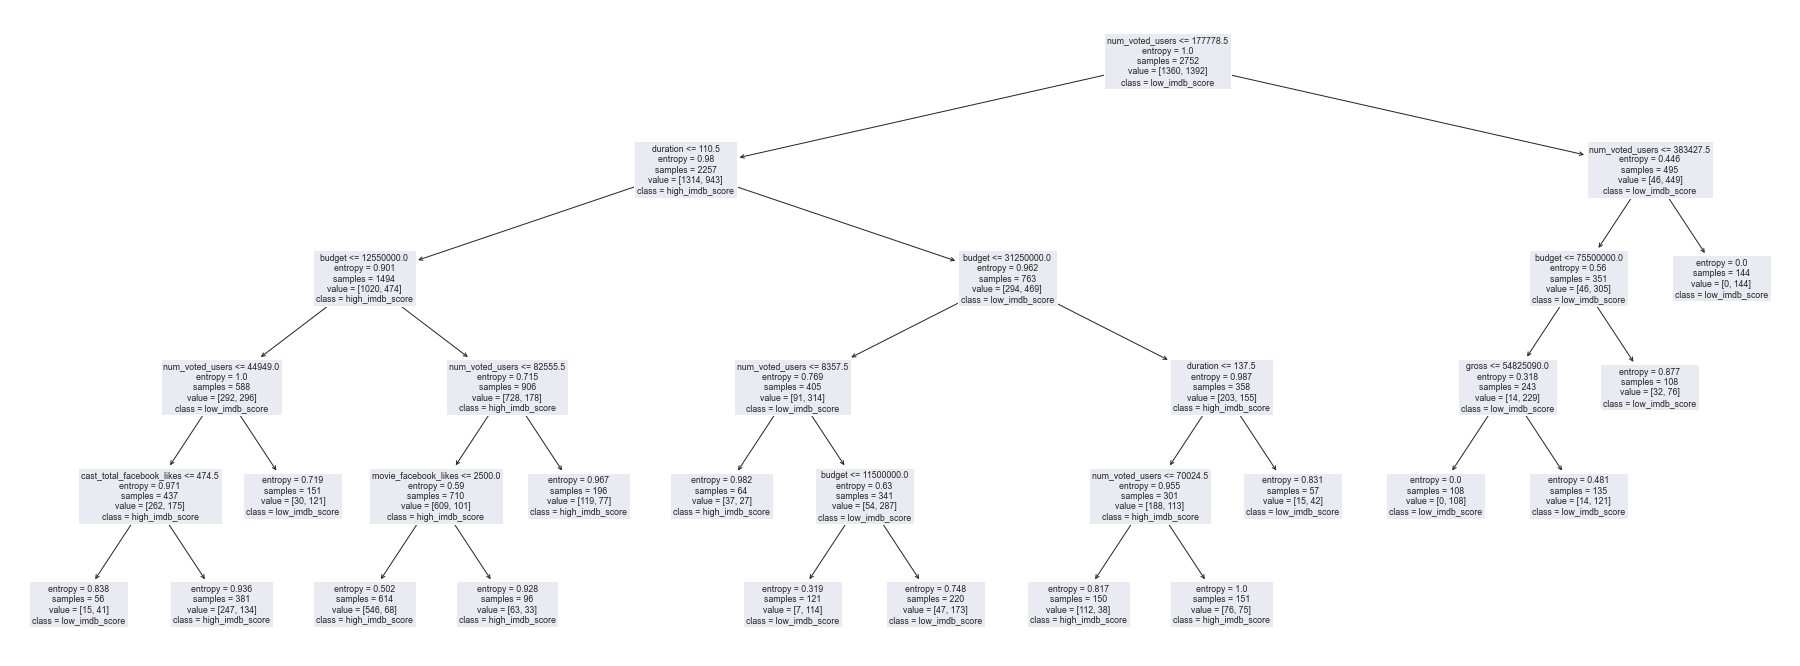

In [ ]:
plt.figure(figsize=(32,12)) 
plot_tree(DT2,feature_names=X_test.columns,class_names=target_names)

### Interpret the feature importance

In [ ]:
feature_impact=pd.DataFrame()
feature_impact['features']=X_test.columns
feature_impact['impact']=DT2.feature_importances_
feature_impact

,features,impact
0,num_critic_for_reviews,0.000000
1,duration,0.166531
2,director_facebook_likes,0.000000
3,gross,0.013643
4,num_voted_users,0.533789
5,cast_total_facebook_likes,0.023190
6,facenumber_in_poster,0.000000
7,num_user_for_reviews,0.000000
8,budget,0.239100
9,title_year,0.000000


In [ ]:
#let find ROC and AUC score
#before we calculate roc_auc_score(), we need to find out the predicted probabilities for test data.
pred_prob = pd.DataFrame(DT2.predict_proba(X_test))
#we'll also add the actual label
test_result=y_test
test_result.columns=['actual']
test_result = test_result.reset_index()
test_result['prob_0'] = pred_prob.iloc[:,0]
test_result['prob_1'] = pred_prob.iloc[:,1]
# test_result['prob_2'] = pred_prob.iloc[:,2]
test_result.head()

,index,actual,prob_0,prob_1
0,589,0,0.503311,0.496689
1,1214,1,0.213636,0.786364
2,42,1,0.000000,1.000000
3,2640,1,0.648294,0.351706
4,1713,0,0.889251,0.110749


In [ ]:
y_test

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)
y_test1=pd.DataFrame(enc.transform(y_test).toarray())
y_test1.head()

/Users/dhanabordeemekintharanggur/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- actual
Feature names seen at fit time, yet now missing:
- high_imdb_score

  warnings.warn(message, FutureWarning)


,0,1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [ ]:
#accuracy for each class
metrics.roc_auc_score(y_test1,test_result[['prob_0','prob_1']],average=None)

array([0.83190077, 0.83190077])

/Users/dhanabordeemekintharanggur/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


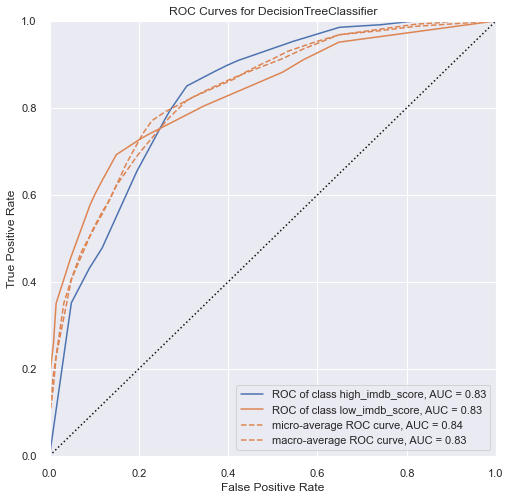

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
#Fast way to draw ROC curve and calculate AUC accuarcies of each class
#from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(DT2, classes=target_names)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()    

##### DT3: with gridserchcv

In [ ]:
DT3=DecisionTreeClassifier()
cv = StratifiedKFold(8)
param_val = [{'criterion':['entropy','gini'],'max_depth':[1,6],'min_samples_split':np.arange(2,10)}]
#grid search configuration
grid = GridSearchCV(DT3, param_val, cv = cv,scoring='roc_auc_ovr')
#fitting into our data
grid.fit(X_train, y_train)

#Predict the response for test dataset

y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)

In [ ]:
grid.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'n_jobs': None,
 'param_grid': [{'criterion': ['entropy', 'gini'],
   'max_depth': [1, 6],
   'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc_ovr',
 'verbose': 0}

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

0.8327882014874914
{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}


Classification Report: 
                  precision    recall  f1-score   support

high_imdb_score       0.77      0.87      0.82       341
 low_imdb_score       0.86      0.74      0.79       348

       accuracy                           0.81       689
      macro avg       0.81      0.81      0.80       689
   weighted avg       0.81      0.81      0.80       689
 

Accuracy on train:   0.827 

Accuracy on test:  0.806 



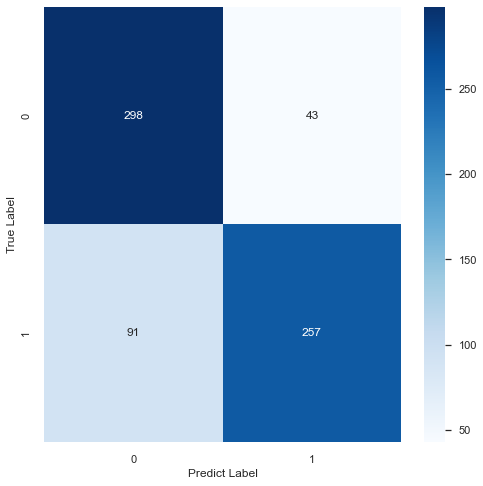

In [ ]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred_2,target_names=target_names),'\n')
print("Accuracy on train:  ",grid.best_estimator_.score(X_train,y_train).round(3),'\n')
print("Accuracy on test: ",grid.best_estimator_.score(X_test,y_test).round(3),'\n')
cf=metrics.confusion_matrix(y_test,y_pred_2).round(3)
sns.heatmap(cf,annot=True,cmap='Blues', fmt="g")
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

In [ ]:
# Get the best decision tree model
best_model = grid.best_estimator_

print(export_text(best_model,feature_names=X_test.columns.tolist()))

|--- num_voted_users <= 142409.50
|   |--- duration <= 110.50
|   |   |--- budget <= 8100000.00
|   |   |   |--- num_voted_users <= 42093.50
|   |   |   |   |--- cast_total_facebook_likes <= 474.50
|   |   |   |   |   |--- gross <= 7271535.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- gross >  7271535.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- cast_total_facebook_likes >  474.50
|   |   |   |   |   |--- num_user_for_reviews <= 49.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- num_user_for_reviews >  49.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- num_voted_users >  42093.50
|   |   |   |   |--- title_year <= 2008.50
|   |   |   |   |   |--- num_user_for_reviews <= 874.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- num_user_for_reviews >  874.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- title_year >  2008.50
|   |   |   |   |   |--- gross <= 54097470.00
|   |   |   |   |   |   |---

[Text(0.5739182692307693, 0.9285714285714286, 'num_voted_users <= 142409.5\ngini = 0.5\nsamples = 2752\nvalue = [1360, 1392]\nclass = low_imdb_score'),
 Text(0.3076923076923077, 0.7857142857142857, 'duration <= 110.5\ngini = 0.48\nsamples = 2115\nvalue = [1267, 848]\nclass = high_imdb_score'),
 Text(0.15384615384615385, 0.6428571428571429, 'budget <= 8100000.0\ngini = 0.421\nsamples = 1427\nvalue = [998, 429]\nclass = high_imdb_score'),
 Text(0.07692307692307693, 0.5, 'num_voted_users <= 42093.5\ngini = 0.498\nsamples = 426\nvalue = [199, 227]\nclass = low_imdb_score'),
 Text(0.038461538461538464, 0.35714285714285715, 'cast_total_facebook_likes <= 474.5\ngini = 0.494\nsamples = 326\nvalue = [181, 145]\nclass = high_imdb_score'),
 Text(0.019230769230769232, 0.21428571428571427, 'gross <= 7271535.0\ngini = 0.355\nsamples = 52\nvalue = [12, 40]\nclass = low_imdb_score'),
 Text(0.009615384615384616, 0.07142857142857142, 'gini = 0.231\nsamples = 45\nvalue = [6, 39]\nclass = low_imdb_score')

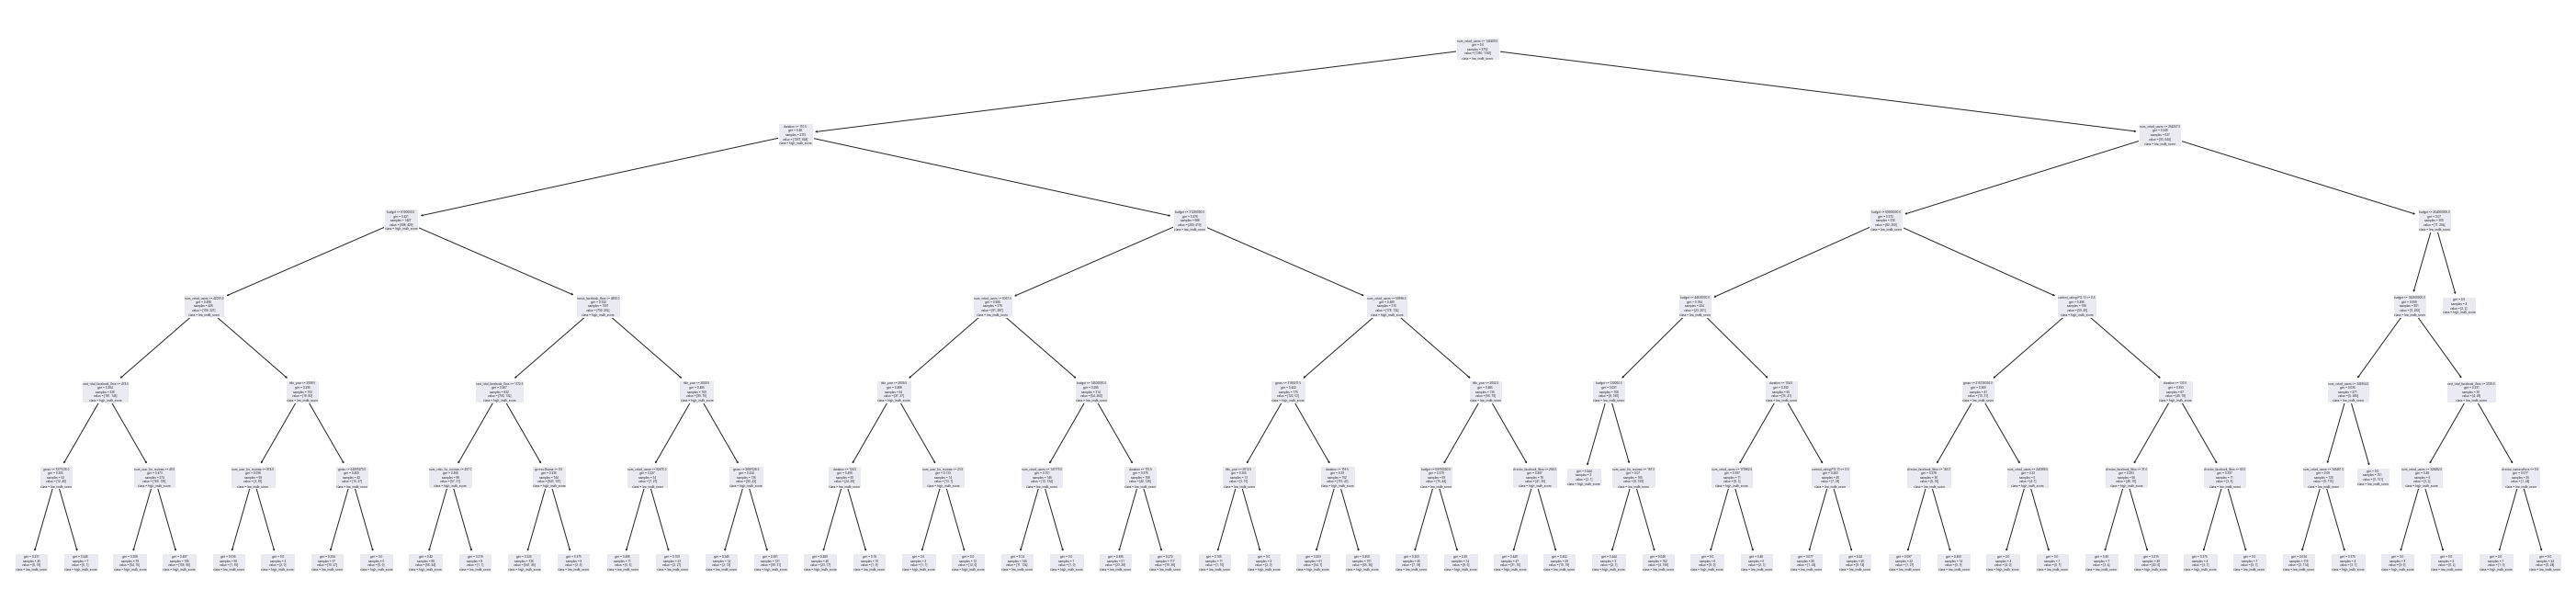

In [ ]:
plt.figure(figsize=(50,12)) 
plot_tree(grid.best_estimator_,feature_names=X_test.columns,class_names=target_names)

### Evaluate classification result of test dataset

In [ ]:
feature_impact=pd.DataFrame()
feature_impact['features']=X_test.columns
feature_impact['impact']=DT2.feature_importances_
feature_impact

,features,impact
0,num_critic_for_reviews,0.000000
1,duration,0.166531
2,director_facebook_likes,0.000000
3,gross,0.013643
4,num_voted_users,0.533789
5,cast_total_facebook_likes,0.023190
6,facenumber_in_poster,0.000000
7,num_user_for_reviews,0.000000
8,budget,0.239100
9,title_year,0.000000


In [ ]:
# print(export_text(grid,feature_names=X_test.columns.tolist()))

In [ ]:
y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)
y_pred_2_prob

array([[0.04      , 0.96      ],
       [0.16239316, 0.83760684],
       [0.        , 1.        ],
       [0.53846154, 0.46153846],
       [0.87092391, 0.12907609],
       [0.53846154, 0.46153846],
       [0.81012658, 0.18987342],
       [0.87092391, 0.12907609],
       [0.        , 1.        ],
       [0.87092391, 0.12907609],
       [0.87092391, 0.12907609],
       [0.81012658, 0.18987342],
       [0.87092391, 0.12907609],
       [0.02469136, 0.97530864],
       [0.65957447, 0.34042553],
       [0.27027027, 0.72972973],
       [0.07586207, 0.92413793],
       [0.87092391, 0.12907609],
       [0.53846154, 0.46153846],
       [0.87092391, 0.12907609],
       [0.87092391, 0.12907609],
       [0.53846154, 0.46153846],
       [0.74380165, 0.25619835],
       [0.87092391, 0.12907609],
       [0.7       , 0.3       ],
       [0.02469136, 0.97530864],
       [0.01724138, 0.98275862],
       [0.87092391, 0.12907609],
       [0.8852459 , 0.1147541 ],
       [0.04      , 0.96      ],
       [0.

In [ ]:
y_test

,actual
589,0
1214,1
42,1
2640,1
1713,0
...,...
1314,0
2269,0
2909,1
2219,0


In [ ]:

metrics.roc_auc_score(y_test['actual'],y_pred_2_prob[:,1],multi_class='ovr')

0.8564524555903867

/Users/dhanabordeemekintharanggur/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


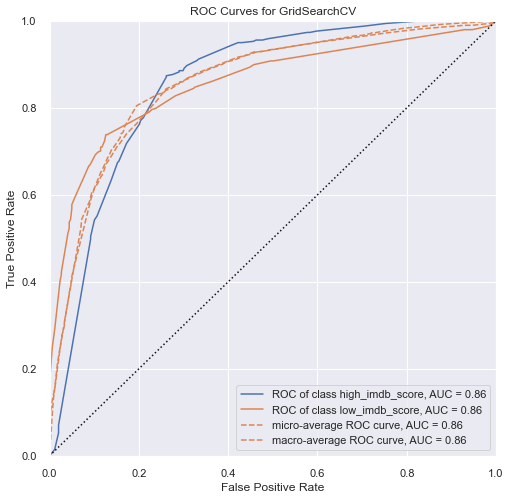

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(grid, classes=target_names)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()

In [ ]:
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()  

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

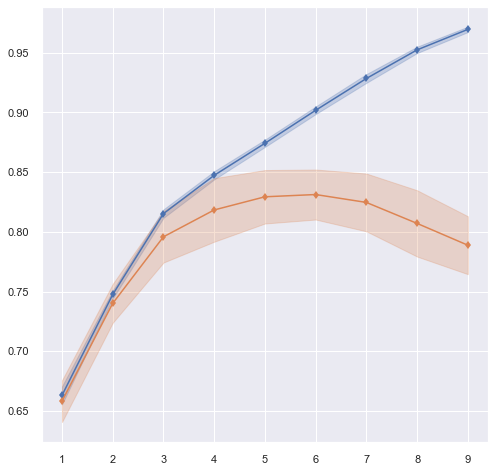

In [ ]:
param_range = np.arange(1, 10, 1)
visualizer = ValidationCurve(
    DecisionTreeClassifier(),param_name="max_depth",
    param_range=param_range, cv=cv, scoring='roc_auc_ovr'
)
visualizer.fit(X_train, y_train)
plt.show()
